# 주제

- 영화에 대한 고객들의 평가 데이터를 가지고, 분석, 예측등등 회귀모델을 통해서 구현
- 회귀의 평가 지표를 사용
- 특성들의 배치와 조합에 따라 지표는 다르게 나올수 있다 => 데이터를 준비하는 과정에 순서, 사용하는 특성 종류등도 영향을 미친다

In [1]:
import numpy as np
import pandas as pd

# 데이터 로드

## 고객정보로드

In [2]:
# 고객 정보 로드
users = pd.read_csv('./content/ml-100k/u.user', sep='|')
users.head(2)
# 그냥 데이터를 올려보니 1번 데이터가 컬럼으로 올라갔다->누락
# 컬럼을 지정하여서 데이터를 읽어야 한다

,1,24,M,technician,85711
0,2,53,F,other,94043
1,3,23,M,writer,32067


In [3]:
# 컬럼
cols = ['uid','age','s','job','zip_code']
cols

['uid', 'age', 's', 'job', 'zip_code']

In [4]:
# 컬럼명을 지정하여 데이터로드
users = pd.read_csv('./content/ml-100k/u.user', sep='|', 
                    names=cols)
users.head(2) 

,uid,age,s,job,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


## 영화정보로드

In [5]:
# 영화 정보 로드
cols = ['mid','title','release_date','video_release_date','url']
movies = pd.read_csv('./content/ml-100k/u.item', sep='|', 
          encoding='latin1', names=cols, usecols=range(5))
movies.head(2)

,mid,title,release_date,video_release_date,url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...


In [6]:
movies.shape, users.shape

((1682, 5), (943, 5))

## 평점정보로드

In [7]:
cols = ['uid','mid','rating','date']
ratings=pd.read_csv('./content/ml-100k/u.data',sep='\t',names=cols) 
ratings.head(2)
# 881250949 -> 1970.01.01 00:00:00초부터 현재까지 진행된시간+9시간
#              시간형식 => long => yyyyMMdd hhmmss
# 881250949 :  -> yyyyMMdd hhmmss : 
# 시간 정보가 직관적이지 않다 직관적인 시간정보로 변환

,uid,mid,rating,date
0,196,242,3,881250949
1,186,302,3,891717742


In [8]:
# date 컬럼의 값을 변경하여서 원 구조에 다시 적용
ratings['date'] = pd.to_datetime( ratings['date'], unit='s' )
ratings.head(2)

,uid,mid,rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22


In [9]:
ratings.shape

(100000, 4)

# 데이터 준비, 분석

- 품질향상
- 시각화
- 통찰(일부진행가능)

## 3개의 데이터를 한개의 DF로 병합

In [10]:
# DataFrame이 1개 이상으로 존재한다 -> 필연적 -> 병합과정
# merge, concat등
# movies + ratings 순으로 병합
movies_ratings = pd.merge(movies ,ratings)
movies_ratings.head(1)

,mid,title,release_date,video_release_date,url,uid,rating,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,1998-02-17 17:28:52


In [11]:
# 평점 데이터를 기준으로 병합 완성
movies_ratings.shape

(100000, 8)

In [12]:
movies_ratings_users = pd.merge(movies_ratings, users)
movies_ratings_users.head(1)

,mid,title,release_date,video_release_date,url,uid,rating,date,age,s,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,1998-02-17 17:28:52,60,M,retired,95076


In [13]:
movies_ratings_users.shape

(100000, 12)

## 데이터 살펴보기

- 특성, 성향등의 데이터의 특징을 확인

In [14]:
movie_datas = movies_ratings_users[:]

In [15]:
# 평가를 가장 많이 받은 작품 상위 10개
# 작품별, 평가수를 구해라 -> 내림차순 정렬 -> 상위 10
# value_counts() 값의 빈도를 계산해서, 정렬(기본값), 내림차순(기본값)
movie_datas.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [16]:
tmp = movie_datas.title.value_counts()[-5:]
type(tmp)

pandas.core.series.Series

In [17]:
tmp

Tainted (1998)                    1
Wend Kuuni (God's Gift) (1982)    1
Brother's Kiss, A (1997)          1
Century (1993)                    1
Modern Affair, A (1995)           1
Name: title, dtype: int64

In [18]:
# 조건         : 평가 개수가 1개인 영화만
# 결과 or 수행 : 모아라
# 조건식
tmp = movie_datas.title.value_counts()
#res = tmp[  tmp <= 10  ]
res = tmp[  tmp == 1  ]

# 전체 데이터중에 평점이 1개만 존재하는 영화의 비율
res.shape[0]/movies.shape[0]*100
# 통찰 => 평점은 특정 평가 개수 이상 존재할 경우만 인정 (검토)
# 임계값 설정 => 평점 개수 몇개 이상!!

7.966706302021404

In [19]:
# 제목 기준으로 데이터를 배치, 평가의 개수, 평균평점 2개를 feature로 
# 가지는 데이터 프레임을 생성하시오
# 인덱스 : 영화제목, 컬럼:평가개수, 평균평점
# rating : 1차 레벨 컬럼
# [np.size, np.mean] : 2차 레벨 컬럼
movie_state = movie_datas.groupby('title').agg( { 
                'rating':[np.size, np.mean] } )
movie_state.head(2)

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000

In [20]:
# 영화 원본 데이터 대비, 평가수가 0개인 데이터는 누락되었을수도 있다
movie_state.shape, movies.shape

((1664, 2), (1682, 5))

In [21]:
movie_state.rating['size'][:2]

title
'Til There Was You (1997)    9
1-900 (1994)                 5
Name: size, dtype: int64

In [22]:
# 이런 영화들 중에 평가가 100개이상만 모아라 
movies_100_over = movie_state[ movie_state['rating']['size'] >=100 ]

In [23]:
# 평가 개수가 100개인 데이터만 모아서, 평점 기준 정렬
tmp = movies_100_over.sort_values( by=[ ('rating','mean') ],
                                  ascending=False )
tmp.head(2)

rating          
                          size      mean
title                                   
Close Shave, A (1995)      112  4.491071
Schindler's List (1993)    298  4.466443

In [24]:
tmp.tail(2)

rating          
                        size      mean
title                                 
Jungle2Jungle (1997)     132  2.439394
Cable Guy, The (1996)    106  2.339623

In [25]:
# 회원이 평가를 얼마나 했는가 기준점으로 확인
# 사용자별 평가 횟수
tmp = movie_datas.groupby('uid').size()
tmp[:5]

uid
1    272
2     62
3     54
4     24
5    175
dtype: int64

In [26]:
from matplotlib import pyplot as plt

In [27]:
tmp.sort_values( ascending=False ).head(2)

uid
405    737
655    685
dtype: int64

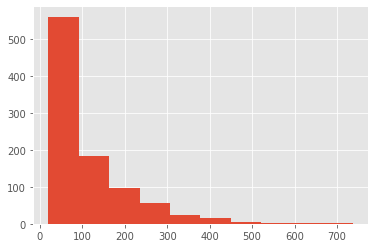

In [28]:
plt.style.use('ggplot')
tmp.sort_values( ascending=False ).hist()
# "지프의 법칙"을따르는 데이터 굴곡 모양이다. 롱테일분포
# 영화의 평가 개수가 많으면 많을수록 1개만 평가한 데이터도 많아진다

In [29]:
# 사용자별 평가 회수, 평균
user_state = movie_datas.groupby('uid').agg({'rating':[np.size, np.mean]})
user_state.head(10)

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677
3       54  2.796296
4       24  4.333333
5      175  2.874286
6      211  3.635071
7      403  3.965261
8       59  3.796610
9       22  4.272727
10     184  4.206522

In [30]:
user_state.rating.describe()
# 최저,최고 점수는 편중되어 있는것으로 보인다

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


# 데이터 모델링

- libFM을 python으로 wapping한 fastFM 제품
사용
- fastFM은 리눅스(우분트 추천), 맥에서 설치가 가능

In [ ]:
! pip install fastFM

## fastFM

- 설치
  - ! pip install fastFM

- 알고리즘을 만들고 싶다 -> 1~2~3년 (연구기관, 대기업등 진행) -> 논문
  - 언어 : C / C++등 랭귀지 + 수학적 증명
  - 파이썬 래핑 : Cython 사용가능
  - 파이썬 라이브러리 제작

- 사용이유
  - 특성 사이의 영향을 주고 받는 상호 작용 개념을 계산에 적용하여 처리할수 있다(조합, 순서등도 성능을 개선하는데 관여된다)
  - 범주형 변수를 더미(파생)변수로 변환하여 범주간 상호작용성도 계산에 사용할수 있다
  - 회귀, 분류
  - 행렬 인수 분해 머신기능을 탑재하고 있다

- 제공 알고리즘
  - ALS  : 교대 최소 제곱법
    - 장점 : 예측 시간 빠름. 파라미터수 적다 
    - 단점 : 규제하면서 학습처리
  - SGD  : 확률적 경사 하강법
    - 장점 : 예측 시간 빠름, 대규모 데이터를 빠르게 학습할수 있다
    - 단점 : 규제, 하이퍼라라미터가 많다
  - MCMC : 마로코프 연쇄 몬테카롤로
    - 장점 : 하이퍼파라미터 작다 
    - 단점 : 학습 속도 느리다


## 가상데이터를 이용하여 기능 확인

In [ ]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [ ]:
from fastFM import als
from sklearn.model_selection import learning_curve

In [ ]:
# DictVectorizer => 문자열을 백터화 
v = DictVectorizer()

In [ ]:
train = [
  { 'user':'1', 'item':'5',  'age':19 },
  { 'user':'2', 'item':'43', 'age':33 },
  { 'user':'3', 'item':'20', 'age':55 },
  { 'user':'4', 'item':'10', 'age':20 }
]
train

In [ ]:
# 데이터를 백터화하여 수치로 표현
X = v.fit_transform( train )
# 수치는 그대로 둔다
# 문자열을 범주형 변수로 취급되어, 총 케이스수만큼 컬럼이 생성,
# 0으로 채운뒤에 독립된값에 1으로 부여식으로 데이터가 변환, 
# 순서는 중요하지않다
X.toarray()

In [ ]:
# y 제공 => 평점
# user1은 5.0부여, user2는 1.0부여, user3은 2.0을 부여...
y = np.array( [ 5.0, 1.0, 2.0, 4.0 ] )

In [ ]:
# 알고리즘 생성
fm = als.FMRegression( n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)

In [ ]:
# 훈련
fm.fit(X, y)

In [ ]:
# 예측 ; 나이가 24살인데 아이템 10번을 보고 평점을 몇점줄까?
data = {'user':'5', 'item':'10', 'age':24}
fm.predict( v.transform(data) )

## 학습에 필요한 데이터 준비 

- ua.base (훈련용), ua.test (테스트용)

In [ ]:
# ua.base
# uid, mid, rating, ts 이렇게 구성되어 있다
# 데이터 => [ {'uid':'1', 'mid':'100'}, .... ]
# 레이블 => [ 1.0, 3.0, 5.0,... ] => [ 1.0 3.0 5.0 ... ]
# 이렇게 결과물이 나오도록 함수 or 구현하시오

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  data  = list()
  array = list()    
  with open( f'{dir}/{filename}' ) as f:    
    for line in f:      
      uid, mid, rating, _ = line.split('\t')      
      data.append( {'uid':uid, 'mid':mid } )
      array.append( float(rating) )      
  return ( data, np.array(array) )
loadData( 'ua.base' ) # ua.test

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  data  = list()
  array = list()    
  with open( f'{dir}/{filename}' ) as f:    
    for line in f:      
      uid, mid, rating, _ = line.split('\t')      
      data.append( {'uid':uid, 'mid':mid } )
      array.append( float(rating) )
      break
      pass
    pass
  return ( data, np.array(array) )
loadData( 'ua.base' ) # ua.test

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  data  = list()
  array = list()  
  # 파일을 읽어서(한줄씩) => 바로 원하는 형태로 처리
  with open( f'{dir}/{filename}' ) as f:
    # 한줄씩 읽는다 
    for line in f:
      #print( line.split('\t') )
      # 데이터 추출
      uid, mid, rating, _ = line.split('\t')
      # 데이터를 모양에 맞춰서 추가
      print( type(uid), type(mid)  )
      #data.append( {'uid':'1', 'mid':'100'} )
      data.append( {'uid':uid, 'mid':mid } )
      break
      pass
    pass

  return ( data, np.array(array) )
loadData( 'ua.base' ) # ua.test

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  data  = list()
  array = list()  
  
  return ( data, np.array(array) )
loadData( 'ua.base' ) # ua.test

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  data  = [ {'uid':'1', 'mid':'100'} ]
  array = np.array( [ 1.0, 3.0, 5.0 ] )
  
  return ( data, array )
loadData( 'ua.base' ) # ua.test

In [ ]:
def loadData( filename, dir='./content/ml-100k' ):
  pass
loadData( 'ua.base' ) # ua.test

### 데이터 로드

In [ ]:
X_train, y_train = loadData( 'ua.base' )# 훈련용
X_test,  y_test  = loadData( 'ua.test' )# 테스트용

In [ ]:
# 훈련용 데이터의 크기
len(X_train), y_train.shape

In [ ]:
# 테스트용 데이터의 크기
len(X_test), y_test.shape

In [ ]:
# 훈련용 데이터의 백터화
v = DictVectorizer()

In [ ]:
X_train_v = v.fit_transform( X_train )
X_train_v.shape, type(X_train_v)

In [ ]:
# 값확인
X_train_v.toarray()

In [ ]:
X_test_v = v.transform( X_test )
X_test_v.shape, type(X_test_v)

In [ ]:
X_test_v.toarray()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 사용 데이터는 
# X_train, y_train  => 훈련용으로 사용 => split 처리 9:1로 나눠라
# X_test, y_test    => 예측으로 사용
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(
  X_train_v, y_train, test_size=0.1, random_state=1 )

In [ ]:
X_train_dev.shape, X_test_dev.shape

## 훈련 및 예측,평가

- MCMC
  - 학습와 예측을 동시에 수행
  - 실시간 적이면 SGD로 교체가 적합
  - 파라미터 값들과, 평균제곱근오차값을 저장하여서
  - 값들이 어떻게 수렴해가는지 시각화 하여
  - 최적위치를 찾는다

In [ ]:
# MSE : 평균제곱근오차 함수 -> 회귀모델에서 평가지표중 한개
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

In [ ]:
# 1. 임계값, 하이퍼파라미터 설정(시작값, 기본값) <- 실험치를 미리 설정
n_iter = 300 # 300회 반복
rank   = 4   # 하이퍼파라미터가 rank*2배로 증가된다 => 고정크기(3) + 2*rank
seed   = 123 # 난수의 시드(설정값), 시드가 고정되면 셔플 or 학습시 사용되는
             # 난수가 일정하게 나온다 => 시간에 관계없이 동일한 결과를 산출
             # 난수를 변경하면, 반복학습시 데이터도 변경되게 할수 있다
             # 고정된 데이터에서 다양성을 확보할수 있다
step_size = 1 

In [ ]:
# 2. 알고리즘 생성
fm = mcmc.FMRegression( n_iter=0, rank=rank, random_state=seed )

In [ ]:
# 3. 학습 및 예측
fm.fit_predict( X_train_dev, y_train_dev, X_test_dev )

In [ ]:
# 4. 결과치를 담는 자료구조 준비
# 손실값 = np.sqrt(mean_squared_error()) <- 평가지표 
rmse_test = list()
# 하이퍼파라미터 => 배열 => 초기값은 0
hyper_params = np.zeros( ( n_tier-1, 3 + 2*rank ), dtype=np.float64 )
hyper_params.shape

In [ ]:
hyper_params[ 1, : ]

In [ ]:
# 5. n차번 수행하면서 예측 성능과, 하이퍼파라미타 수치를 저장한다
# 인덱스와 횟수값은 별도로 관리
for nr, i in enumerate( range(1, n_tier) ):
  # 난수 seed 조정 -> 학습및 예측시 다양성을 확보 -> 반복학습시 동일 데이터로 
  # 수행하는것은 의미가 없다 -> 새로운 데이터를 계속 넗어주는것이 좋다
  # 데이터가 한정되어 있다면 => 난수를 변경해서 조합을 변경
  fm.random_state = i*seed
  # 학습 및 예측시, 재료 데이터의 다양성을 확보를 위해서
  # 난수 조정, n_more_iter 조정으로 데이터의 다양성을 추구하여
  # 항상 다른 종류의 데이터의 조합으로 학습 및 예측하겠끔 유도
  y_pred = fm.fit_predict( X_train_dev, y_train_dev, X_test_dev, n_more_iter=step_size )

  #if nr >=n_tier-3 or nr <3:
  #  print( nr, i )
  # hyper_prams에 파라미터 값들을 추가
  # hyper_pram_의 0:alpha
  # hyper_pram_의 1:lambda_w
  # hyper_pram_의 2:mu_w
  hyper_params[ nr, : ] = fm.hyper_param_ # [ 0.00,.... 0.88 ], (11, )

  # rmse_test에 값을추가
  rmse_test.append( np.sqrt(mean_squared_error( y_test_dev, y_pred ))  )

  pass

In [ ]:
# 6. 결과치를 시각화하여 데이터가 수렴하는 위치를 확인
#    수렴한다 => 더 학습해봤자 성능의 변화가 없다
#    성능측정
print(rmse_test[:3]), 
print(rmse_test[:-3]),
hyper_params

In [ ]:
x = np.arange( 1, n_tier )
x

In [ ]:
# 결과 데이터를 시각화 처리 
# 2x2로 차트 배치 (선형)
# rmse, alpha, lambda_w, mu_w를 시각화 
from matplotlib import pyplot as plt 

# 차트 외관, 2x2, x축 공유, 가로가 길게 
fig, axes = plt.subplot( nrows=2, ncols=2, sharex=True, figsize=(15,8) )

# 드로잉 
# x축 : 시도 횟수 n차, 1 ~ 299  
axes[0,0].plot( x, rmese_test, label='rmse', color='r' )
axes[0,0].legend()

axes[0,1].plot( x, hyper_params[:,0], label='alpha', color='g' )
axes[0,1].legend()

axes[1,0].plot( x, hyper_params[:,1], label='lambda_w', color='b' )
axes[1,0].legend()

axes[1,1].plot( x, hyper_params[:,2], label='mu_w', color='r' )
axes[1,1].legend()

In [ ]:
# 초기값과 후반부 값이 너무 편차가 크다 
# 초기값을 어느 정도 제거하고 처리하자 
burn_in = 5

from matplotlib import pyplot as plt 

fig, axes = plt.subplot( nrows=2, ncols=2, sharex=True, figsize=(15,8) )
x1 = x[burn_in:]
axes[0,0].plot( x1, rmese_test[burn_in:], label='rmse', color='r' )
axes[0,0].legend()
axes[0,1].plot( x1, hyper_params[burn_in:, 0], label='alpha', color='g' )
axes[0,1].legend()
axes[1,0].plot( x1, hyper_params[burn_in:, 1], label='lambda_w', color='b' )
axes[1,0].legend()
axes[1,1].plot( x1, hyper_params[burn_in:, 2], label='mu_w', color='r' )
axes[1,1].legend()

In [ ]:
# 반복횟수가 150회 이상 진행이 되면 하이퍼 파라미터들이 안정화 되어간다
# 평균제곱근 오차의 손실함수 값의 최소값 
print( np.min(rmse_test) )
# 이 값을 더 줄여 보는 쪽으로 진행 
# 횟수, 시드 고정, 랭크 값을 조정

In [ ]:
n_iter = 100 # n_iter : 데이터를 훈련하는 횟수
seed = 333
rmse_test2 = list()
ranks = [4,8,16,32,64]

# 랭크 개수대로 반복 
for rank in ranks : 
    # 알고리즘 새로 생성
    # rank 를 제외한 하이퍼파라미터 고정 후 rank 변화로 rmse 값 추이 추적 
    mcmc.FMRegression( n_iter=n_iter, rank=rank, random_state=seed )
    # 학습 후 예측         
    y_pred = fm.fit_predict( X_train_dev, y_train_dev, X_test_dev, n_more_iter=step_size )
    # 손실값 = np.sqrt( mse ) # sqrt : 제곱근 계산 
    rmse_test2.append( np.sqrt(mean_squared_error( y_test_dev, y_pred )) )
    print( rmse_test2[-1] ) # [-1] : 방금 추가된 값 
    # 손실함수 : 출력값과 정답의 오차를 정의하는 함수

In [ ]:
plt.plot( ranks, rmse_test2, label='rmse', color='r' )
plt.legend()

In [ ]:
for i, pre in enumerate(y_pred) : 
    

In [ ]:
X_test_v.shape

In [ ]:
# ua.test로 준비된 데이터 => 이것을 이 모형에 넣어서 성능을 측정 
# 하이퍼파라미터 고정값 : n_iter=300, rank=32, seed=333
# 1. 알고리즘 생성 
fm = mcmc.FMRegression( n_iter=300, rank=32, seed=333 )
# 2. 훈련 및 예측 ( X_test_v )
y_pred = fm.fit_predict( X_train_v, y_train, X_test_dev )
# 3. rmse 출력 (평가잣대 y_test )
np.sqrt( mean_squared_error( y_test, y_pred ) ) 

- 선응이 더 떨어졌다
- 평점 자체가 편차가 크다
- 평점을 정규화하여 조정 
- StandardScaler 사용 
- 대상
    - y_train, y_test 

In [ ]:
# 7. 성능을 높이기 위해서 -> 정규화를 넣어보자 등등...
from sklearn.preprocessing import StandardScaler 

In [ ]:
y_train.reshape(-1,1), y_train.reshape(-1,1).shape

In [ ]:
# type(y_train), y_train.ndim

In [ ]:
scaler = StandardScaler()
# reshape(-1,1) => 함수가 2D를 원해서 형태 변경
# ravel() => 훈련시 1D를 원하니까 데이터를 1차로 펼쳤다 
y_train_norm = scaler.fit_trainsform( y_train.reshape(-1,1) ).ravel()

In [ ]:
y_train_norm

In [ ]:
# 8. 컬럼의 조합 및 순서를 바꿔서 교차로 검증해 보자

In [ ]:
# 정규화한 평점 정보를 가지고 수행시 성능 향상이 있는지 검토 
fm = mcmc.FMRegression( n_iter=300, rank=32, seed=333 )
y_pred = fm.fit_predict( X_train_v, y_train_norm, X_test_dev )
# 예측값을 정규화 전으로 되돌린다 => 원래 값으로 복원 
np.sqrt( mean_squared_error( y_test, scaler.inverse_transform(y_pred) ) ) 
# 약간의 성능이 개선됨 

## 종합 

In [ ]:
# 1. 임계값, 하이퍼파라미터 기본값 준비 
n_iter = 200
step_size = 1
seed = 123
rank = 32 

# 알고리즘 생성 
fm = mcmc.FMRegression( n_iter=0, rank=rank, random_state=seed )
fm.fit_predict( X_train_v, y_train_norm, X_test_v )

# 결과물 담기 
rmse_test = list()
hyper_params = np.zeros( ( n_iter-1, 3+2*rank ), dtype=np.float64 )

# 학습 및 예측을 n_iter만큼 수행 
for nr, i in enumerate( range(1, n_iter) ) :
    fm.random_state = i * seed
    y_pred = fm.fit_predict( X_train_v, y_train_norm, X_test_v, n_more_iter=step_size )
    rmse_test.append( np, sqrt(mean_squared_error(y_test, scaler.inverse_transform(y_pred) )))
    rmse_test.append(tmp)
    hyper_params[nr, :] = fm.hyper_param
    
# 시각화 
burn_in = 5
x = np.arange( 1, n_iter )
x = x * step_size  

fig, axes = plt.subplot( nrows=2, ncols=2, sharex=True, figsize=(15,8) )

x1 = x[burn_in:]

axes[0,0].plot( x1, rmese_test[burn_in:], label='rmse', color='r' )
axes[0,0].legend()
axes[0,1].plot( x1, hyper_params[burn_in:, 0], label='alpha', color='g' )
axes[0,1].legend()
axes[1,0].plot( x1, hyper_params[burn_in:, 1], label='lambda_w', color='b' )
axes[1,0].legend()
axes[1,1].plot( x1, hyper_params[burn_in:, 2], label='mu_w', color='r' )
axes[1,1].legend()

# 최소값 => 78번째에서 가장 저점이 나왔다 
print( np.min(rmse_test), np.argmin(rmse_test) )

In [ ]:
hyper_params[np.array{}]

## 컬럼을 다양하게 적용 

In [ ]:
# 8. 컬럼의 조합 및 순서를 바꿔서 교차로 검증해보자 

In [ ]:
movie_datas.head(2)

In [ ]:
movie_datas.dtypes

In [ ]:
movie_datas.columns 

In [ ]:
# uid, mid를 문자열 변환 
# year라는 컬럼 추가 > date에서 yyyy를 추출하여서 문자열로 추가 
# DataFrame에서 진행 

movie_datas['uid'] = movie_datas.uid.astype(str)
movie_datas['mid'] = movie_datas.uid.astype(str)

In [ ]:
mobie_datas['year'] = movie_dates['date']

In [ ]:
# 컬럼 조합 후보 (순서 중요)
candidates_cols = [
    ['uid','mid','age','s','year','rating'],
    ['uid','mid','s','year','rating'], 
    ['uid','mid','age','s','rating'],
    ['uid','mid','s','age','rating'], 
    ['uid','mid','rating']
] 